In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from config import *

In [5]:
csv_file = data_meta / "all_info.csv"

# Read dataframe containing images information
df = pd.read_csv(csv_file)

In [6]:
df.Location = df.Location.astype(str)

In [7]:
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as utils

# Read masks image and corresponding intensity measurement

In [8]:
# Read mask image
masks = utils.get_masks(data_mask)

# Create image based on intensity level of expression 

In [9]:
df_intensity = pd.read_csv(data_meta / "measurements_intensity.csv")
df_morph = pd.read_csv(data_meta / "measurements_morphology.csv")
markers = df_intensity.Marker.unique()

In [10]:
# Calculate total intensity from mena intensity and area size
for row in df_intensity.itertuples():
    cond = row.Location
    i = row.Id
    total_nuclei_intensity = (
        row.Nuclei_mean_intensity
        * df_morph[(df_morph.Location == cond) & (df_morph.Id == i)][
            "Nuclei_area"
        ].item()
    )
    total_cyto_intensity = (
        row.Cyto_mean_intensity
        * df_morph[(df_morph.Location == cond) & (df_morph.Id == i)]["Cyto_area"].item()
    )
    df_intensity.loc[row.Index, "Nuclei_total_intensity"] = total_nuclei_intensity
    df_intensity.loc[row.Index, "Cyto_total_intensity"] = total_cyto_intensity

We have {{len(markers)}} markers (no including DAPI and cell segmentation markers) 

# Vizualisation

In [11]:
def get_data_per_condition(df_intensity, scaler, condition=None):
    # Read information
    df = df_intensity.iloc[:, 3:]
    if condition:
        df_subset = df[df.Location == condition]
        df_subset.drop(["Location"], axis=1, inplace=True)
    else:
        df_subset = df.iloc[:, -2:]
        df_subset["Marker"] = df.Marker
        df_subset["Id"] = df.Location.astype(str) + "_" + df.Id.astype(str)
    df_subset.rename(
        columns={"Nuclei_total_intensity": "Nuclei", "Cyto_total_intensity": "Cyto"},
        inplace=True,
    )

    # Pivot the dataframe
    df_per_cell = df_subset.pivot(
        index="Id", columns=["Marker"], values=["Nuclei", "Cyto"]
    )

    # Scale the data
    x_scaled = scaler.fit_transform(df_per_cell)
    df_per_cell_scaled = pd.DataFrame(
        x_scaled, index=df_per_cell.index, columns=df_per_cell.columns
    )

    return df_per_cell_scaled

In [13]:
scaler = StandardScaler()
my_cmap = "bwr"
scale_name = "Z-score"

## Per FOV

In [12]:
condition = 3  # Select the condition

# scaler = MinMaxScaler()
# my_cmap = 'viridis'
# scale_name = 'Relative Intensity'

scaler = StandardScaler()
my_cmap = "bwr"
scale_name = "Z-score"

df_per_cell_scaled = get_data_per_condition(df_intensity, scaler, condition=condition)
df_per_cell_scaled.head()

C:\Users\thu71\.conda\envs\spatial_signaling\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\thu71\.conda\envs\spatial_signaling\lib\site-packages\pandas\core\frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Nuclei                                                              \
Marker       AKT       APC     AXIN1   B-actin   B-tubin Cyclin D1  Cyclin E   
Id                                                                             
1      -1.418715 -0.941689 -1.431351 -1.254010 -1.300875 -1.307732 -1.177541   
2      -0.683271  1.067033  0.780525 -0.650603 -0.072033 -0.039079 -0.507842   
3      -0.047998 -0.014417 -0.232653 -0.051286 -0.046403  0.123081 -0.075181   
4      -0.848869 -0.428708 -0.955884 -0.724474 -0.617416 -0.987371 -1.069539   
6      -1.602707 -1.284004 -1.621445 -1.406102 -1.514080 -1.445713 -1.744396   

                                      ...            Cyto            \
Marker      DKK1      DKK2      EGFR  ... Non-p-B-catenin      PCNA   
Id                                    ...                             
1      -1.375394 -1.484807 -1.328992  ...       -1.115363 -1.022153   
2       2.066303  0.599337  0.768568  ...       -0.826675 -0.931923   
3       0.130909 -0.048297  0.327379  ...       -0.546418 -0.402862   
4      -0.962305 -0.912130 -0.599464  ...       -1.350029 -1.005215   
6      -1.729436 -1.713209 -1.679667  ...       -1.562837 -1.316580   

                                                                       \
Marker Phalloidin    RNF 43      Wnt1      mTOR     p-AKT p-B-catenin   
Id                                                                      
1       -1.161133 -1.038994 -1.007419 -1.061769 -1.142838   -1.061928   
2       -0.274167 -0.868916 -0.526433 -0.664778 -0.439260   -1.031073   
3       -0.792472 -0.245729  0.453568 -0.102209 -0.322237   -0.726850   
4       -1.124544 -1.146369 -1.360383 -1.138183 -1.215419   -1.109638   
6       -1.205796 -1.428572 -1.520041 -1.465955 -1.361993   -1.260226   

                            
Marker    p-EGFR    p-mTOR  
Id                          
1      -1.181052 -1.048792  
2      -0.153481 -0.915362  
3      -0.240628 -0.552423  
4      -1.153595 -1.096236  
6      -1.380471 -1.297559  

[5 rows x 50 columns]

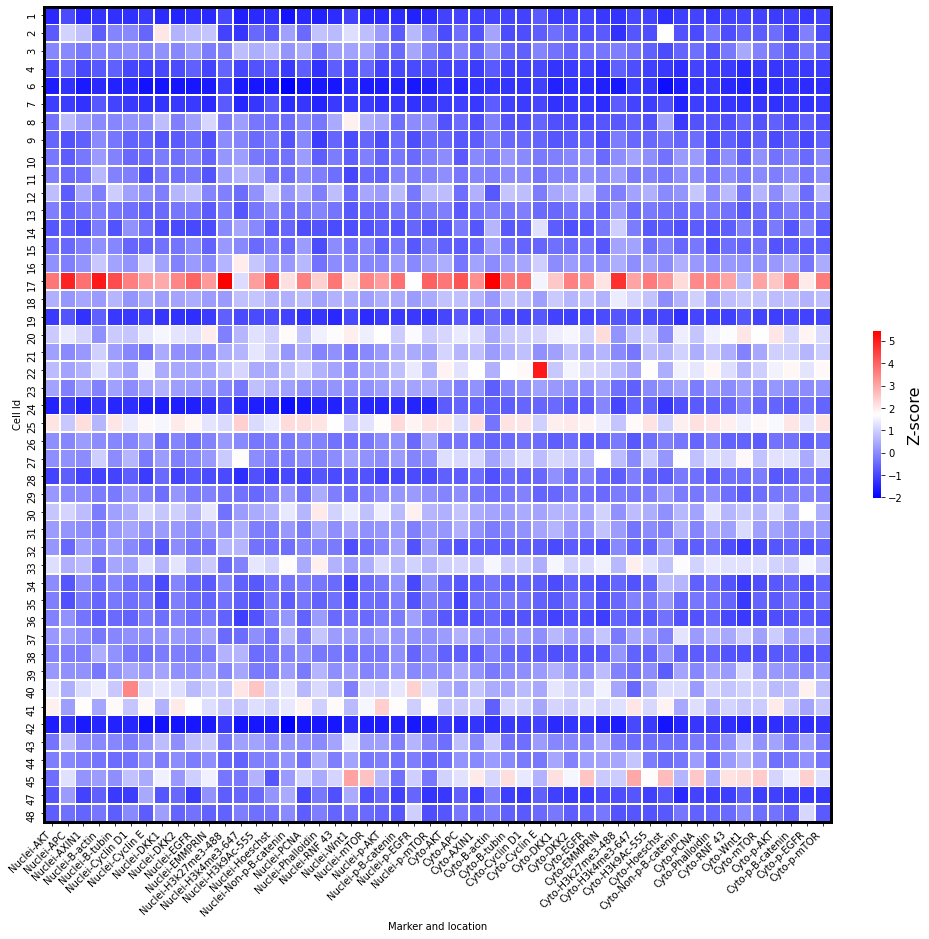

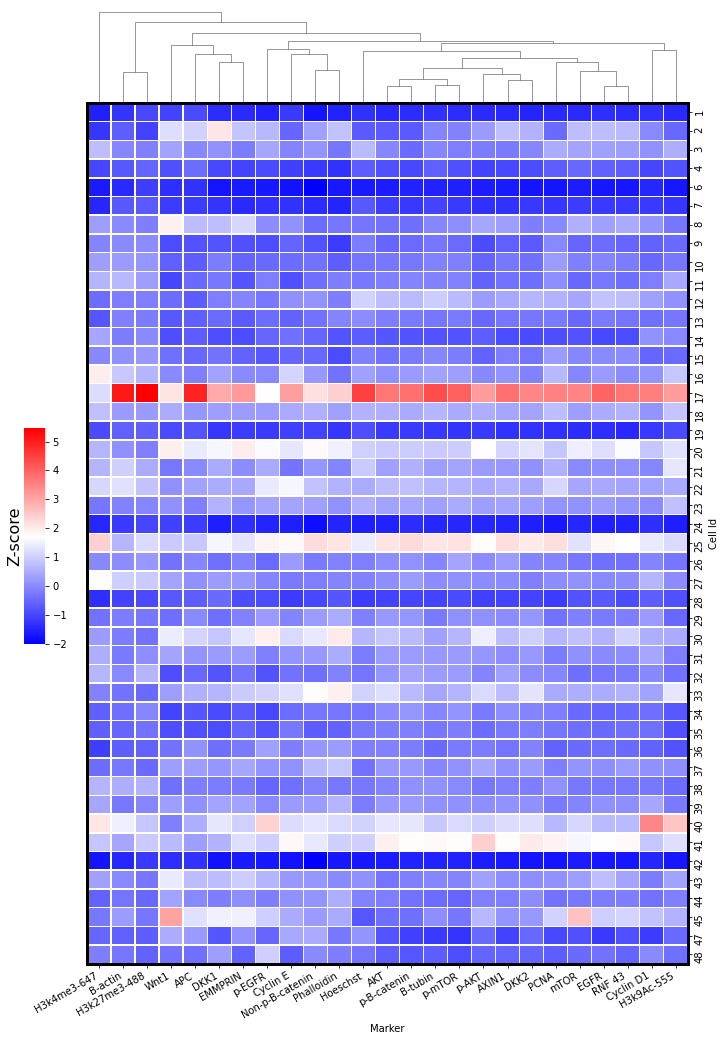

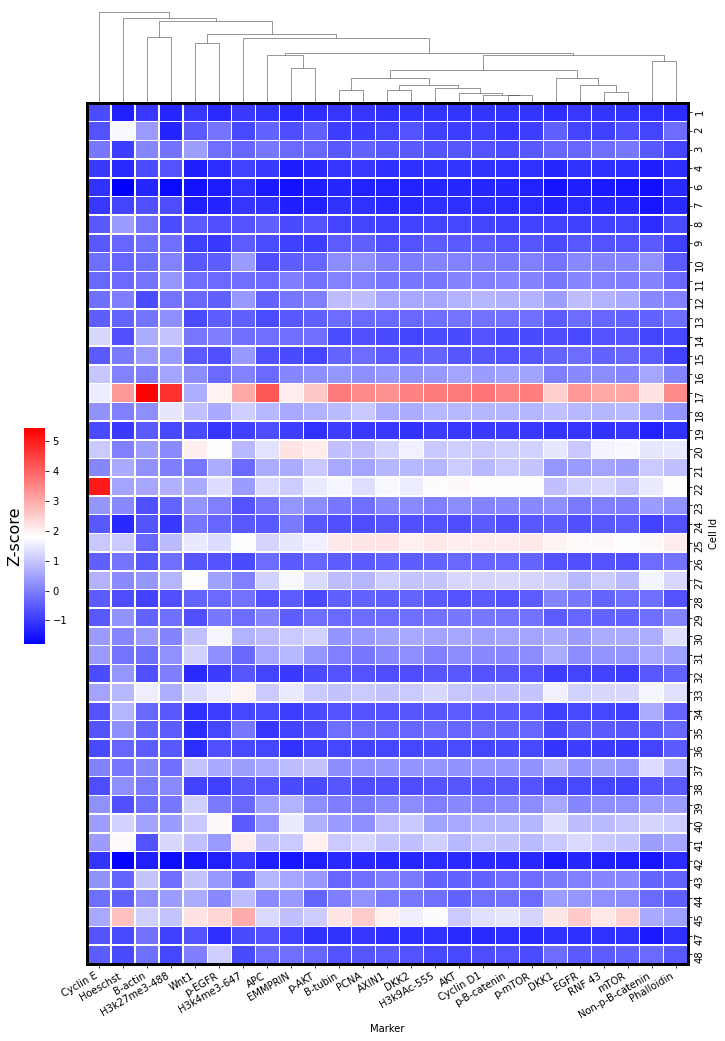

In [13]:
# Heatmap combined
fig, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(
    df_per_cell_scaled, cbar_kws={"fraction": 0.01}, cmap=my_cmap, linewidth=0.5
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
ax.set_xlabel("Marker and location")
ax.set_ylabel("Cell Id")

# Change colorbar label position
cbar = ax.collections[0].colorbar
cbar.set_label(scale_name, fontsize=16)

for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)

# Clustermap nuclei
ax = sns.clustermap(
    df_per_cell_scaled["Nuclei"],
    cbar_kws={"fraction": 0.01},
    cmap=my_cmap,
    linewidth=0.5,
    row_cluster=False,
    dendrogram_ratio=(0.1, 0.1),
    cbar_pos=(0.02, 0.4, 0.03, 0.2),
    figsize=(10, 15),
)
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xticklabels(), rotation=30, horizontalalignment="right"
)
ax.ax_heatmap.set_xlabel("Marker")
ax.ax_heatmap.set_ylabel("Cell Id")

# Change colorbar label position
cbar = ax.ax_heatmap.collections[0].colorbar
cbar.set_label(scale_name, fontsize=16, labelpad=-60)

for _, spine in ax.ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)

# Clustermap cyto
ax = sns.clustermap(
    df_per_cell_scaled["Cyto"],
    cbar_kws={"fraction": 0.01},
    cmap=my_cmap,
    linewidth=0.5,
    row_cluster=False,
    dendrogram_ratio=(0.1, 0.1),
    cbar_pos=(0.02, 0.4, 0.03, 0.2),
    figsize=(10, 15),
)
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xticklabels(), rotation=30, horizontalalignment="right"
)
ax.ax_heatmap.set_xlabel("Marker")
ax.ax_heatmap.set_ylabel("Cell Id")

# Change colorbar label position
cbar = ax.ax_heatmap.collections[0].colorbar
cbar.set_label(scale_name, fontsize=16, labelpad=-60)

for _, spine in ax.ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)

## All FOV

In [14]:
df_per_cell_scaled = get_data_per_condition(df_intensity, scaler)
df_per_cell_scaled.head()

Nuclei                                                              \
Marker       AKT       APC     AXIN1   B-actin   B-tubin Cyclin D1  Cyclin E   
Id                                                                             
10_1   -1.073902 -1.026432 -1.306209 -1.292862 -1.202713 -0.907788 -0.622984   
10_10   0.788813  0.135832 -0.329273  0.234301  0.626069  1.277716  2.001935   
10_11   0.086895 -0.529487 -0.961005 -0.010592 -0.199381 -0.089477  0.668501   
10_12  -0.528278 -0.567428 -1.329253 -0.321822 -0.767360 -0.402792  0.306827   
10_13  -0.862749 -0.591109 -1.314148 -0.725654 -1.567541 -1.020969  0.104666   

                                      ...            Cyto            \
Marker      DKK1      DKK2      EGFR  ... Non-p-B-catenin      PCNA   
Id                                    ...                             
10_1   -0.986681 -0.792524 -1.001430  ...       -0.873938 -0.881558   
10_10   0.262939  1.137914  0.617801  ...        0.289908  1.442612   
10_11  -0.427736  0.572452 -0.091379  ...       -0.542952  0.073944   
10_12  -0.601881  0.019503 -0.412350  ...       -0.741176 -0.600308   
10_13  -0.824538 -0.427106 -1.334448  ...       -0.801963 -0.991913   

                                                                       \
Marker Phalloidin    RNF 43      Wnt1      mTOR     p-AKT p-B-catenin   
Id                                                                      
10_1    -0.871481 -0.749535 -0.753178 -0.759641 -0.730975   -0.815163   
10_10    0.677989  1.799934  1.406384  1.840565  1.386715    1.852844   
10_11   -0.343894  0.365331 -0.012426  0.309193 -0.111638    0.255627   
10_12   -0.604888 -0.326616 -0.219127 -0.299426 -0.518549   -0.483579   
10_13   -0.785482 -0.713666 -0.282454 -0.578104 -0.416552   -0.830556   

                            
Marker    p-EGFR    p-mTOR  
Id                          
10_1   -0.704890 -0.773880  
10_10   0.738551  1.642564  
10_11  -0.337457  0.041787  
10_12  -0.601152 -0.547924  
10_13  -0.438910 -0.793228  

[5 rows x 50 columns]

C:\Users\thu71\.conda\envs\spatial_signaling\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


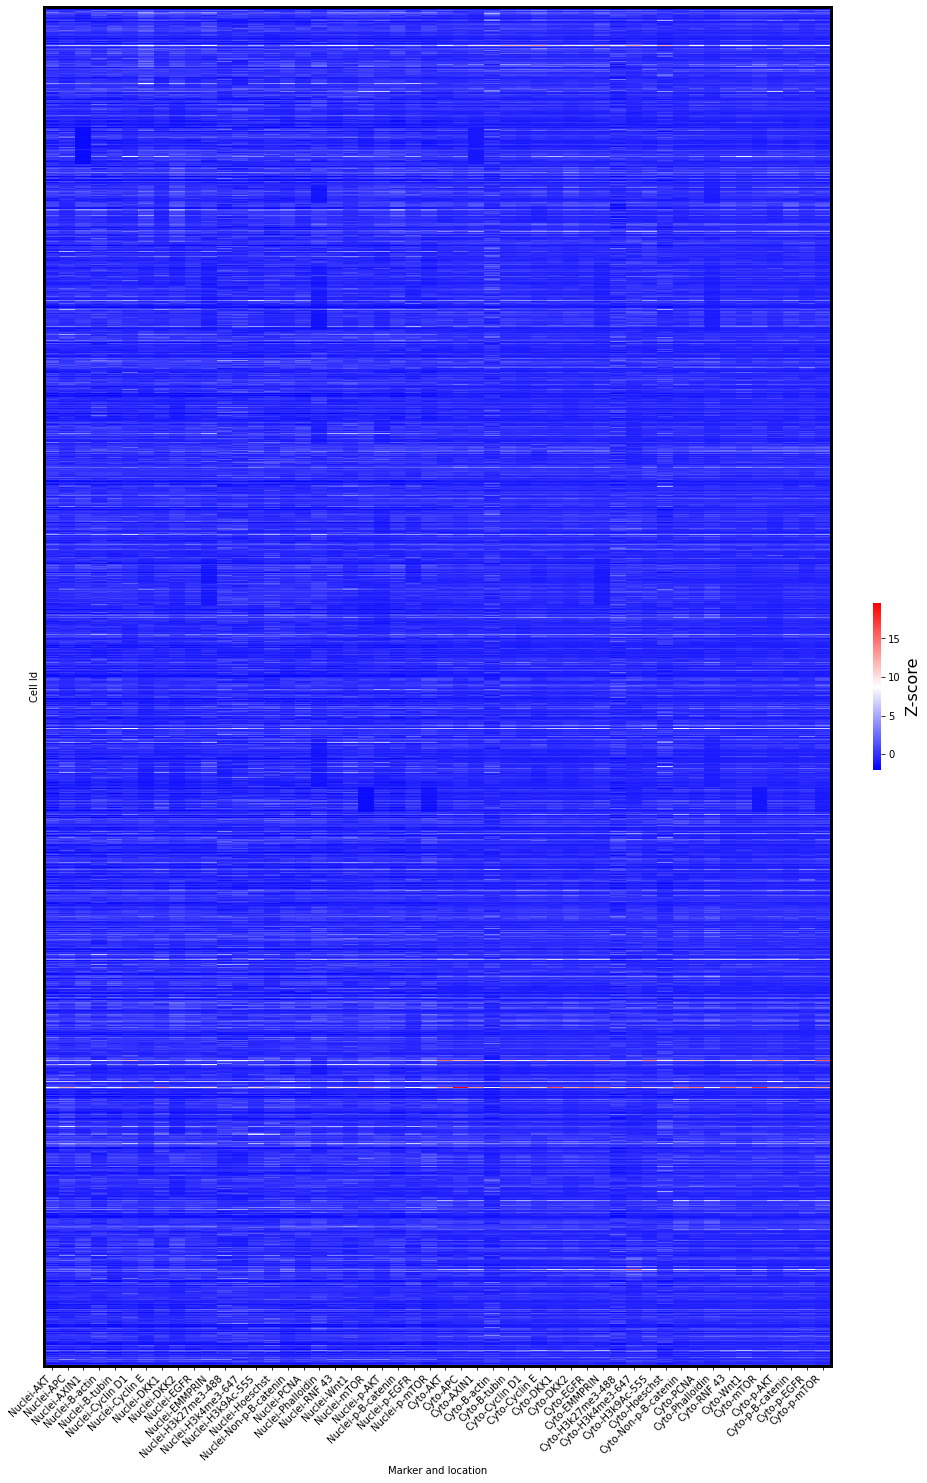

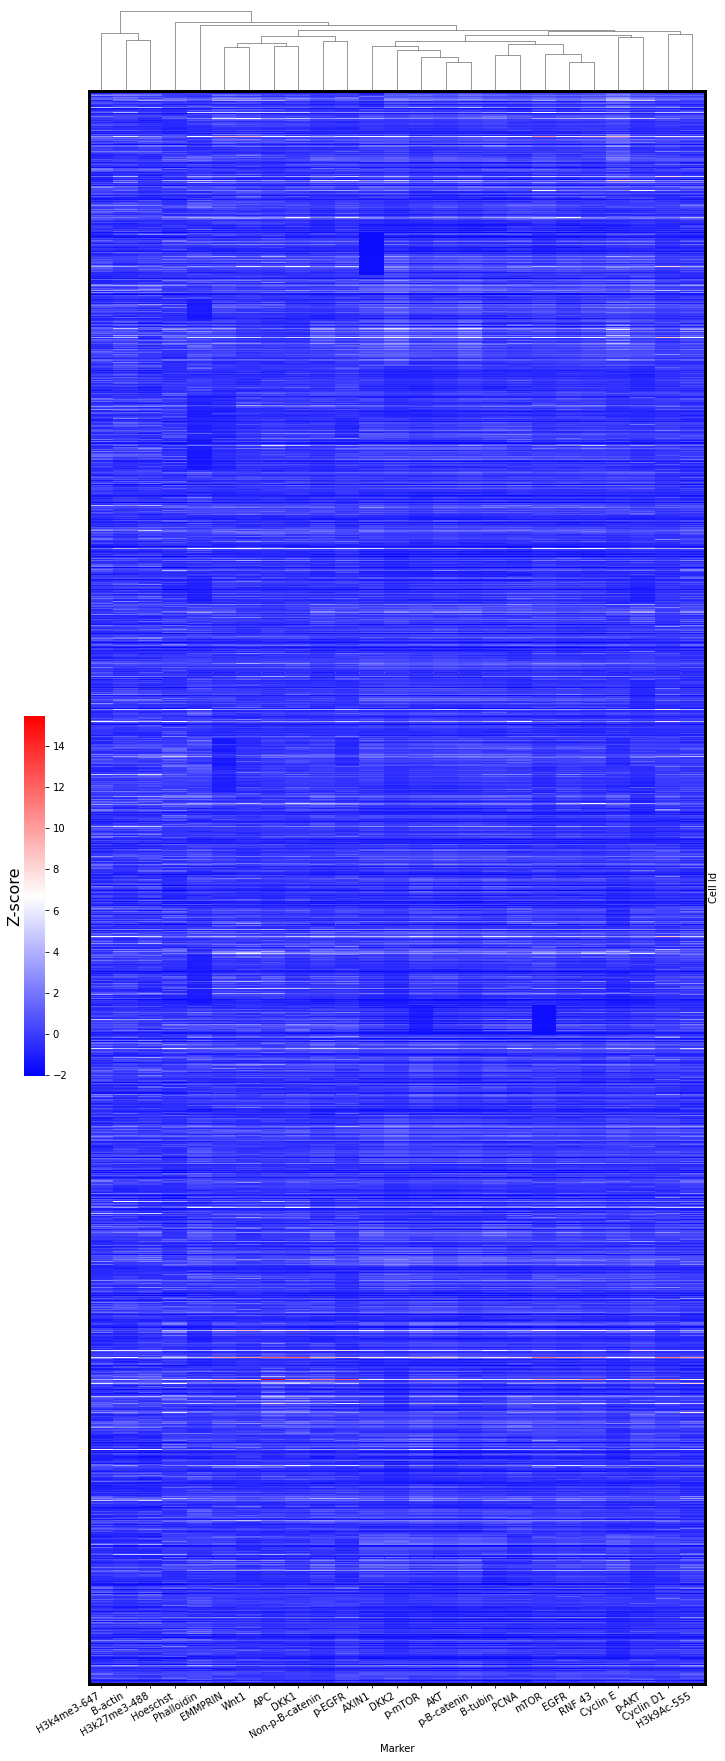

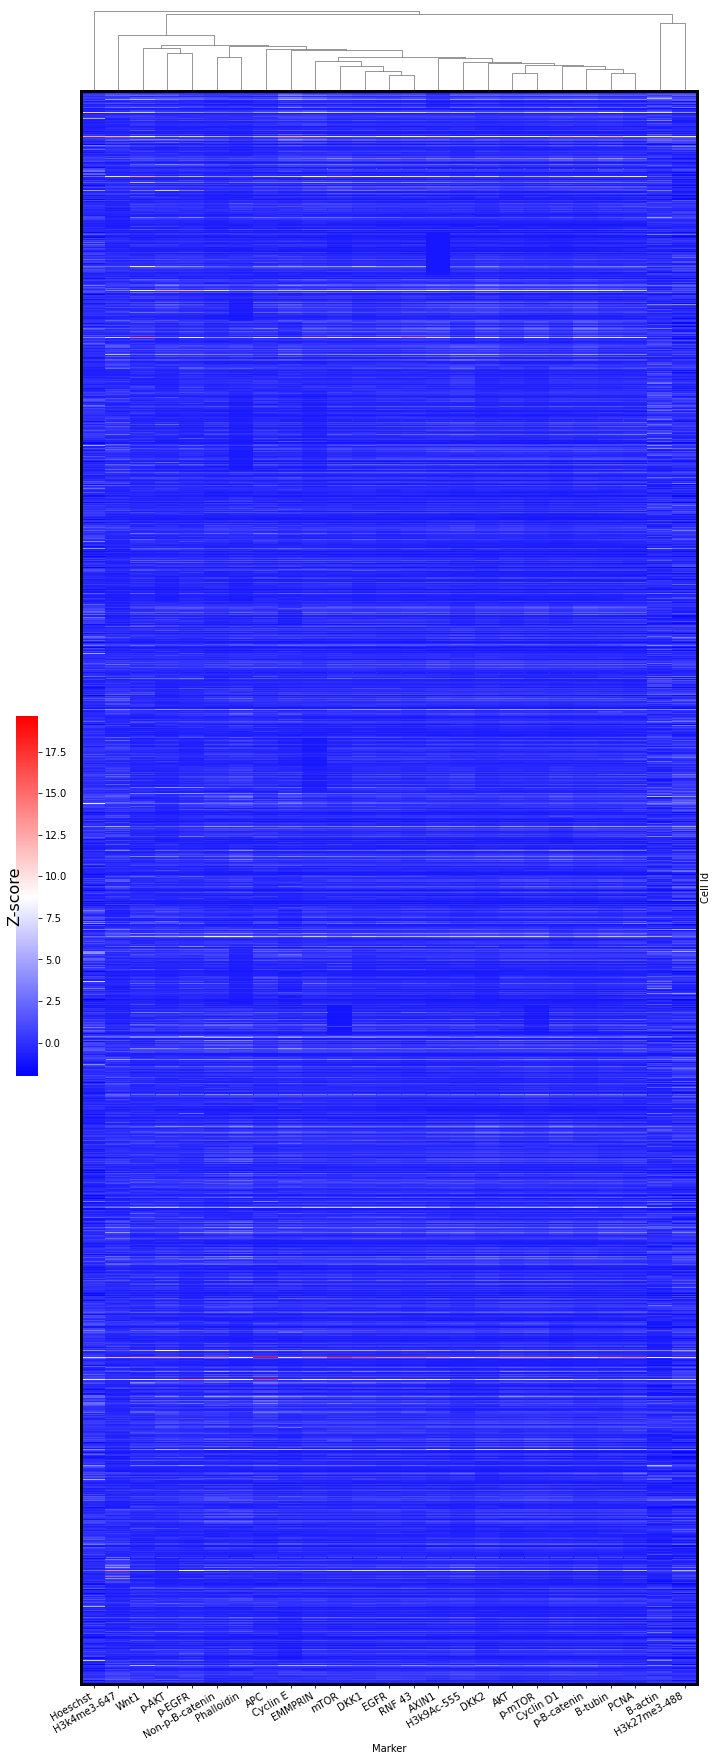

In [18]:
# Heatmap combined
fig, ax = plt.subplots(figsize=(15, 25))
ax = sns.heatmap(
    df_per_cell_scaled,
    cbar_kws={"fraction": 0.01},
    cmap=my_cmap,
    linewidth=0,
    yticklabels=False,
    ax=ax,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
ax.set_xlabel("Marker and location")
ax.set_ylabel("Cell Id")

# Change colorbar label position
cbar = ax.collections[0].colorbar
cbar.set_label(scale_name, fontsize=16)

for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)

# Clustermap nuclei
ax = sns.clustermap(
    df_per_cell_scaled["Nuclei"],
    cbar_kws={"fraction": 0.01},
    cmap=my_cmap,
    linewidth=0,
    row_cluster=False,
    dendrogram_ratio=(0.1, 0.05),
    cbar_pos=(0.02, 0.4, 0.03, 0.2),
    yticklabels=False,
    figsize=(10, 25),
)
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xticklabels(), rotation=30, horizontalalignment="right"
)
ax.ax_heatmap.set_xlabel("Marker")
ax.ax_heatmap.set_ylabel("Cell Id")

# Change colorbar label position
cbar = ax.ax_heatmap.collections[0].colorbar
cbar.set_label(scale_name, fontsize=16, labelpad=-60)

# Clustermap cyto
for _, spine in ax.ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)

ax = sns.clustermap(
    df_per_cell_scaled["Cyto"],
    cbar_kws={"fraction": 0.01},
    cmap=my_cmap,
    linewidth=0,
    row_cluster=False,
    dendrogram_ratio=(0.1, 0.05),
    cbar_pos=(0.02, 0.4, 0.03, 0.2),
    yticklabels=False,
    figsize=(10, 25),
)
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xticklabels(), rotation=30, horizontalalignment="right"
)
ax.ax_heatmap.set_xlabel("Marker")
ax.ax_heatmap.set_ylabel("Cell Id")

# Change colorbar label position
cbar = ax.ax_heatmap.collections[0].colorbar
cbar.set_label(scale_name, fontsize=16, labelpad=-60)

for _, spine in ax.ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(3)